# Layer Visualization

The following notebook can be used to visualize which layers are adapted by TAPS for each experiment. The percentage of parameters changed are also calculated. 

In [71]:
#Import packages. You'll need to install seaborn, matplotlib, and pandas
import torch
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import timm
from models.taps_net import resnet50, resnet101, resnet34

In [72]:
#Set the model architecture
model = resnet50()

#Set your experiment folders and root
model_names = ['CUBS', 'DN_sketch']
experiment_root = './results/'

#Set the gating threshold used during training. (Default is .1)
threshold = .1

In [76]:
activated_params = []
accs = []
scores = []
for j in model_names:
    acc = 100 - np.min(np.load(experiment_root + j + '/val_err.npy'))
    accs.append(acc)
    model_file = experiment_root + j + '/model_best.pth'
    state_dict = torch.load(model_file)['state_dict']
    del state_dict['fc.weight']
    del state_dict['fc.bias']
    model.load_state_dict(state_dict, strict = False)
    indicators = []
    params = model.named_parameters()
    param_dict = dict(model.named_parameters())
    total = 0
    active = 0
    for i in params:
        if not('residual' in i[0]):
            total += i[1].numel()
        if 'bn' in i[0]:
            active += i[1].numel()
        
        if 'indicator' in i[0] and i[1] >= threshold:
            w = param_dict[i[0][:-9] + 'weight']
            active += w.numel()
    activated_params.append(active/total)
    score = model.getIndicators()
    score = [float(x[0]) for x in score]
    scores.append(score)
df = pd.DataFrame([activated_params], columns=model_names, index = ['% Parameters Changed'])
df = df.style.set_caption("Ratio of Parameters Adapted by Task")
df

,cubs_r50_cropped_2,cubs_r50_cropped_3
% Parameters Changed,0.609517,0.299237


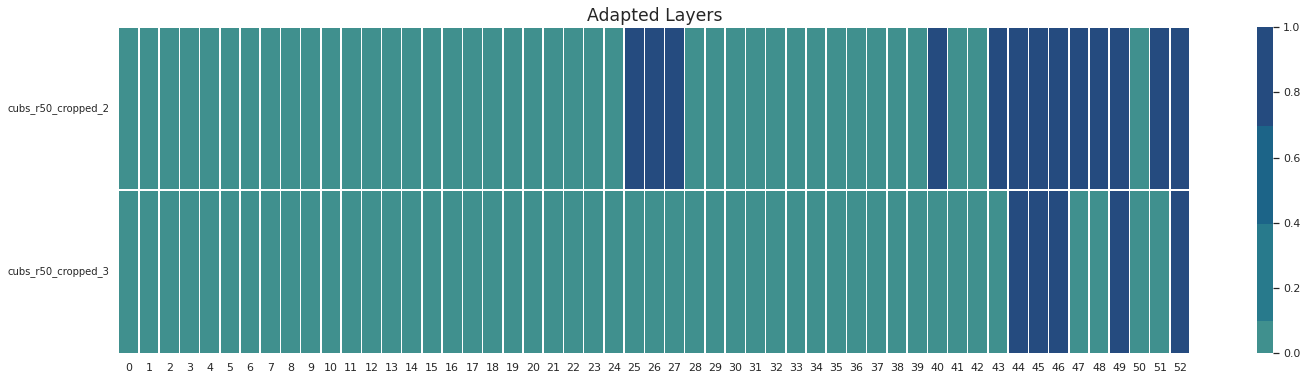

In [74]:
#Plot which layers have been modified by TAPS. Layer 0 is the first layer of the network.
on = np.array(scores) > .1
ax = sns.heatmap(on, linewidth=0.5, cmap = sns.color_palette("crest"), center = .1, yticklabels=model_names)
sns.set(rc = {'figure.figsize':(24,6)})
plt.yticks(np.arange(len(model_names))+0.5,model_names,
           rotation=0, fontsize="10", va="center")
plt.title("Adapted Layers", size = 'x-large')
plt.show()